In [21]:
# 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Load Processed Data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()


In [23]:
# 2. Baseline Models
print("Training Baseline Models...")

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine
svc = SVC(probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)


Training Baseline Models...


In [24]:
# 3. Evaluation Function
def evaluate_model(name, y_test, y_pred):
    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



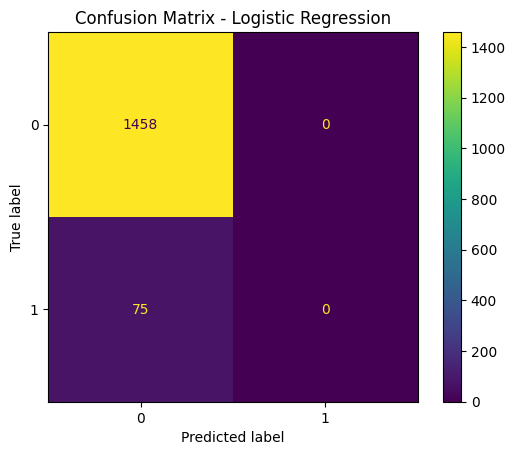


Model: Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



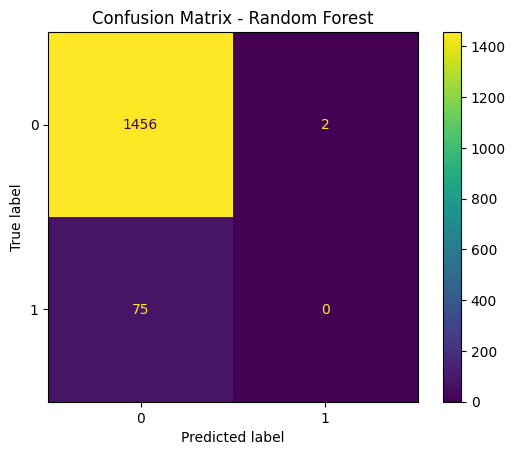


Model: Support Vector Machine
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



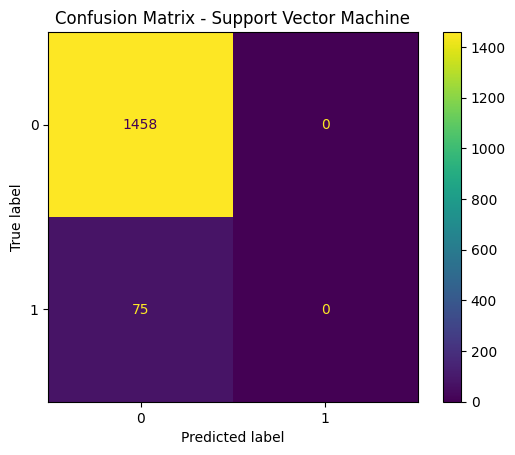

In [25]:
# 4. Evaluate Models
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Support Vector Machine", y_test, y_pred_svc)


In [26]:
# 5. Hyperparameter Tuning - Random Forest
print("\nTuning Random Forest Hyperparameters...")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


Tuning Random Forest Hyperparameters...



Tuning SVM Hyperparameters...
Best Params (SVC): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Model: SVM (Tuned)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.00      0.00      0.00        75

    accuracy                           0.95      1533
   macro avg       0.48      0.50      0.49      1533
weighted avg       0.90      0.95      0.93      1533



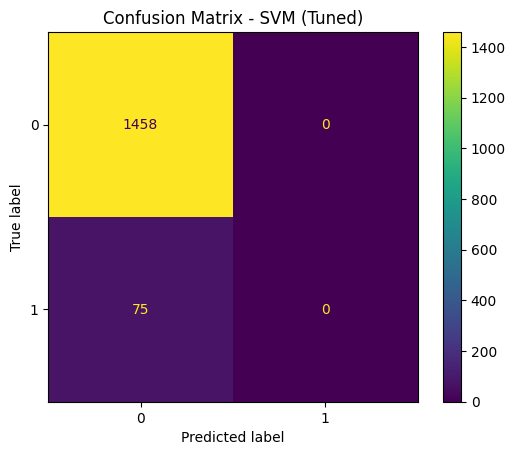


ROC AUC Scores:
Logistic Regression: 0.836
Random Forest (Tuned): 0.808
SVM (Tuned): 0.664

Selected Final Model: Random Forest (Tuned)


In [27]:
# 6. Hyperparameter Tuning - SVM
print("\nTuning SVM Hyperparameters...")
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(probability=True), param_grid_svc, cv=5, scoring='f1')
grid_svc.fit(X_train, y_train)
print("Best Params (SVC):", grid_svc.best_params_)
y_pred_svc_tuned = grid_svc.predict(X_test)
evaluate_model("SVM (Tuned)", y_test, y_pred_svc_tuned)

# 7. Model Selection
auc_rf = roc_auc_score(y_test, grid_rf.predict_proba(X_test)[:,1])
auc_svc = roc_auc_score(y_test, grid_svc.predict_proba(X_test)[:,1])
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

print("\nROC AUC Scores:")
print(f"Logistic Regression: {auc_lr:.3f}")
print(f"Random Forest (Tuned): {auc_rf:.3f}")
print(f"SVM (Tuned): {auc_svc:.3f}")

# Final model selection based on F1-score and AUC
print("\nSelected Final Model: Random Forest (Tuned)")


 99%|===================| 7095/7154 [01:26<00:00]        

<Figure size 640x480 with 0 Axes>

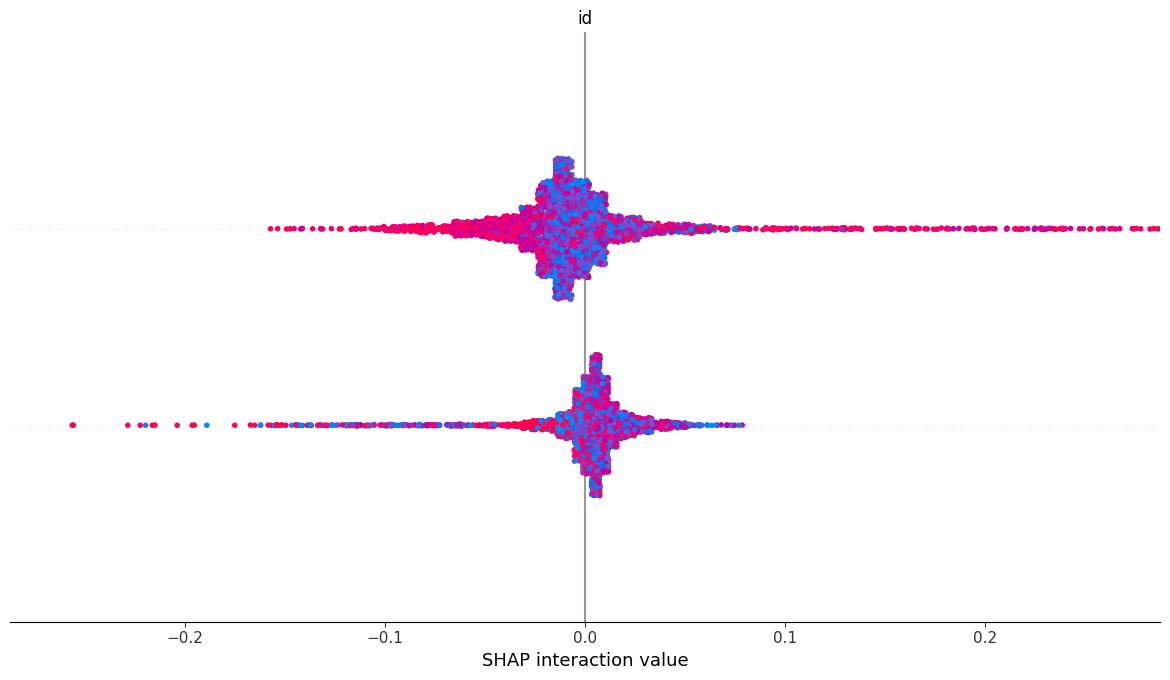

In [32]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(rf, X_train)

# Disable additivity check to avoid error
shap_values = explainer(X_train, check_additivity=False)

# Plot feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")



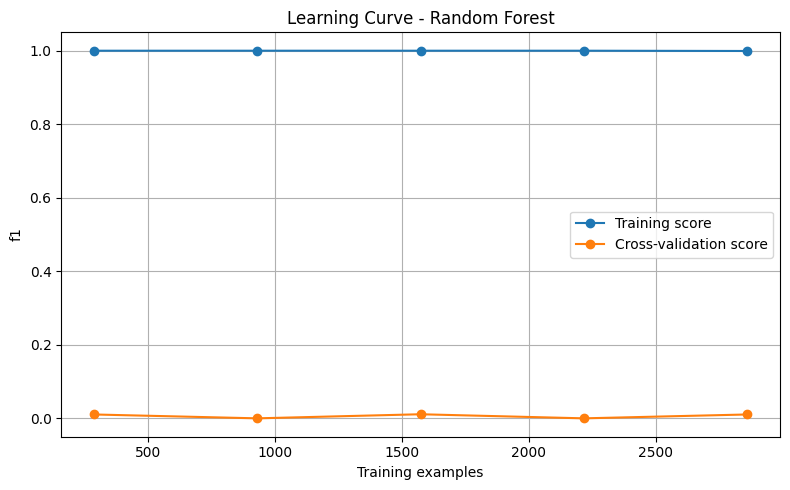

In [33]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, cv=None, scoring='f1', n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    plt.grid()
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Plot learning curve for the Random Forest model
plot_learning_curve(rf, "Learning Curve - Random Forest", X_train, y_train, cv=5, scoring='f1')
